# Assignment 4: Tal Waitzenberg 305578189 , Lital Morali 302491709

First we going to explor and predict the data, we going to fill the missing data fields based on the class example

Let's read the data, we will read the train set and test set and perform the same operations on both.

In [1]:
%pylab inline
import pandas as pd
df = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

Populating the interactive namespace from numpy and matplotlib


Let's look on the missing data by checking the number of nulls/NaNs values in the data set

In [2]:
 df.apply(lambda x: sum(x.isnull()),axis=0) 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Now let's fill the missing data according to class example, we will start from Self_Employed. Let’s look at the frequency table:

In [3]:
df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

We can see that most of the values are "No", so we will fill the 32 missing values "No"

In [4]:
df['Self_Employed'].fillna('No',inplace=True)
df_test['Self_Employed'].fillna('No',inplace=True)

We will do the same for: Dependents, Married, Gender, Loan_Amount_Term, Credit_History

In [5]:
df['Dependents'].value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

We can see that most of the values are "No", so we will fill the 15 missing values "No"

In [6]:
df['Dependents'].fillna(0, inplace=True)
df_test['Dependents'].fillna(0, inplace=True)
df['Married'].value_counts()

Yes    398
No     213
Name: Married, dtype: int64

We can see that most of the values are "Yes", so we will fill the 3 missing values "Yes"

In [7]:
df['Married'].fillna('Yes', inplace=True)
df_test['Married'].fillna('Yes', inplace=True)
df['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

We can see that most of the values are "Male", so we will fill the 13 missing values "Male"

In [8]:
df['Gender'].fillna('Male', inplace=True)
df_test['Gender'].fillna('Male', inplace=True)
df['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

We can see that most of the values are "1", so we will fill the 50 missing values "1"

In [9]:
df['Credit_History'].fillna(1, inplace=True)
df_test['Credit_History'].fillna(1, inplace=True)
df['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

We can see that most of the values are "360", so we will fill the 14 missing values "360"

In [10]:
df['Loan_Amount_Term'].fillna(360, inplace=True)
df_test['Loan_Amount_Term'].fillna(360, inplace=True)

Now, we will create a Pivot table based on the class example, which filled in with the median values of Self_Employed and Education features.

In [11]:
table = df.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
table

Education,Graduate,Not Graduate
Self_Employed,,
No,130.0,113.0
Yes,157.5,130.0


Now let's fill in the missing value of LoanAmount according to the table.

In [12]:
def fage(x):
 return table.loc[x['Self_Employed'],x['Education']]
df['LoanAmount'].fillna(df[df['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)
df_test['LoanAmount'].fillna(df_test[df_test['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

Now let's treat the extreme values of "LoanAmount" by applying log transformation 

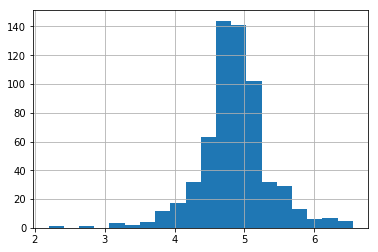

In [13]:
df['LoanAmount_log'] = np.log(df['LoanAmount'])
df_test['LoanAmount_log'] = np.log(df_test['LoanAmount'])
df['LoanAmount_log'].hist(bins=20)

For "ApplicantIncome" let first combine ApplicantIncome and CoapplicantIncome to new column TotalIncome and active log transformation on TotalIncome column.

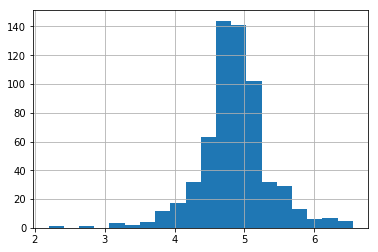

In [14]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'])
df_test['TotalIncome'] = df_test['ApplicantIncome'] + df_test['CoapplicantIncome']
df_test['TotalIncome_log'] = np.log(df_test['TotalIncome'])
df['LoanAmount_log'].hist(bins=20) 

We going to use the EMI formula to calculate the fixed payment amount the borrower needs to pay for a month. the formula is
EMI = [P x R x (1+R)^N]/[(1+R)^N-1], Where P is the Loan Amount, R is rate of interest that around 9%-13%, we assumed for all borrowers the rate of 10%  and N is Loan Amount Term. then we will devide EMI/Total_Income, and we will get a ratio. The idea behind this approach is that greater the EMI/Toatal_Income ratio, there will be less chance for the borrower to pay the loan.

In [15]:
R = 10 / (12 * 100)
df['EMI_Ratio'] = (df['LoanAmount'] * 1000 * R * ((1 + R)**df['Loan_Amount_Term'])) / (((1 + R)**df['Loan_Amount_Term']) - 1)
df['EMI_Ratio/TotalIncome'] = df['EMI_Ratio'] / (df['TotalIncome'] / 12)
df_test['EMI_Ratio'] = (df_test['LoanAmount'] * 1000 * R * ((1 + R)**df_test['Loan_Amount_Term'])) / (((1 + R)**df_test['Loan_Amount_Term']) - 1)
df_test['EMI_Ratio/TotalIncome'] = df_test['EMI_Ratio'] / (df_test['TotalIncome'] / 12)

Now after our findings we can and based on the class example, we can assume that the most important factors are Property_Area, Credit_History and our new factor EMI_Ratio/TotalIncome ratio. based on this 3 factors we will create 2 models.
first we will change the factors type to numbers.

In [16]:
from sklearn.preprocessing import LabelEncoder
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']
le = LabelEncoder()
for i in var_mod + ['Loan_Status']:
    df[i] = le.fit_transform(df[i].astype(str))
for i in var_mod:
    df_test[i] = le.fit_transform(df_test[i].astype(str))  
    
#Import models from scikit learn module:
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import ExtraTreesClassifier

We will start by using the ExtraTreesClassifier model, which is ensemble method. we will train the model on the 3 factors 'Credit_History','Property_Area', 'EMI_Ratio/TotalIncome'.

In [17]:
outcome = 'Loan_Status'
model = ExtraTreesClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictors = ['Credit_History','Property_Area', 'EMI_Ratio/TotalIncome']
#Fit the model:
model.fit(df[predictors],df[outcome])  
#Make predictions on training set:
predictions = np.vectorize((lambda x: "Y" if (x == 1) else "N"))(model.predict(df_test[predictors]))
pd.DataFrame({'Loan_ID': df_test["Loan_ID"],outcome: predictions}).to_csv("submission1.csv", index=False)

We got 0.777778 accuracy. now we will try to improve that by using a linear model. we going to use RidgeClassifier model based on linear regression model. we will train the model on the 3 factors 'Credit_History','Property_Area', 'EMI_Ratio/TotalIncome'.

In [18]:
model = RidgeClassifier()
predictors = ['Credit_History','Property_Area', 'EMI_Ratio/TotalIncome']
#Fit the model:
model.fit(df[predictors],df[outcome])  
#Make predictions on training set:
predictions = np.vectorize((lambda x: "Y" if (x == 1) else "N"))(model.predict(df_test[predictors]))
pd.DataFrame({'Loan_ID': df_test["Loan_ID"],outcome: predictions}).to_csv("submission2.csv", index=False)

We got 0.784722 accuracy. thats an improvement.